## Preparing Input Data 

Activities performed:
*   The data is downloaded as zip files from external sources and saved to drive
*   The zip files are copied to local workspace in collab
*   Unzipping the data into folders







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cp "/content/drive/MyDrive/DS_Projects/APOD_Train.zip" .


In [3]:
cp "/content/drive/MyDrive/DS_Projects/APOD_Valid.zip" .


In [ ]:

!unzip APOD_Train.zip -d training
!unzip APOD_Valid.zip -d validation

## Data Loading

Activities performed:
* create generators by loading the training and validation data from the local workspace
* mentioning the batch size and image size for processing

In [5]:
# Import modules
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16

import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Parameters
IMG_SIZE = 224
IMAGE_SIZE = (IMG_SIZE,IMG_SIZE)
BATCH_SIZE = 20
EPOCHS = 20
STEPS = 10

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training/APOD_Train/",
    shuffle=True, batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE
)

Found 7000 files belonging to 2 classes.


In [8]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "validation/APOD_Valid/",
    shuffle=True, batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE
)

Found 2183 files belonging to 2 classes.


## Input Data Visualisation

Activities Performed:
* Understanding the shape of the image 
* Explored the class distribution in the training data 
* Plotted few samples of training data from both classes 

In [9]:
class_names = train_dataset.class_names
class_names

['Fake', 'Real']

In [10]:
# min max scaling 
def min_max_scale(image):
  image = (image - image.min()) / (image.max() - image.min()) 
  return image

In [11]:
for image, label in train_dataset.take(1):
    print("Shape of the input images batch: ", image.shape)

Shape of the input images batch:  (20, 224, 224, 3)


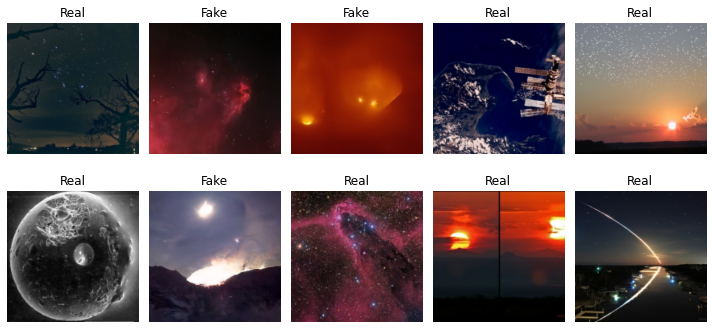

In [12]:
# training data samples
images, labels = next(iter(train_dataset))
i = 0
plt.figure(figsize = (10,5))
for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(min_max_scale(images[i].numpy()))
  plt.title(class_names[labels[i]])
  plt.axis("off")
plt.tight_layout()

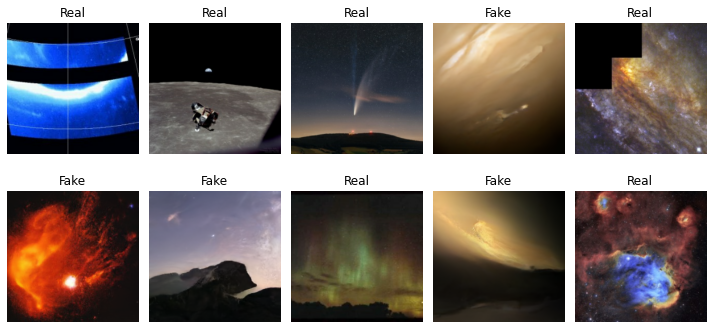

In [13]:
# validation dataset samples
images, labels = next(iter(valid_dataset))
i = 0
plt.figure(figsize = (10,5))
for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(min_max_scale(images[i].numpy()))
  plt.title(class_names[labels[i]])
  plt.axis("off")
plt.tight_layout()

## Model Building

* Loading Pretrained VGGNet model with imagenet weights
* Locking the layers of the pretrained models except the last fully connected layer
* Adding the compiler information 

In [48]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [49]:
# for layer in base_model.layers:
#     layer.trainable = False

In [50]:
# checking the frozen layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [51]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

## Model Training

In [52]:
vgghist = model.fit(train_dataset, validation_data = valid_dataset, steps_per_epoch = STEPS, epochs = EPOCHS)

Epoch 1/20
10/10 [==============================] - 22s 2s/step - loss: 1.9442 - acc: 0.5400 - val_loss: 0.5490 - val_acc: 0.6977
Epoch 2/20
10/10 [==============================] - 16s 2s/step - loss: 0.5514 - acc: 0.6950 - val_loss: 0.5910 - val_acc: 0.6885
Epoch 3/20
10/10 [==============================] - 17s 2s/step - loss: 0.6672 - acc: 0.6550 - val_loss: 0.5082 - val_acc: 0.7403
Epoch 4/20
10/10 [==============================] - 17s 2s/step - loss: 0.4398 - acc: 0.8100 - val_loss: 0.7503 - val_acc: 0.5552
Epoch 5/20
10/10 [==============================] - 17s 2s/step - loss: 0.8403 - acc: 0.6800 - val_loss: 0.5604 - val_acc: 0.6871
Epoch 6/20
10/10 [==============================] - 17s 2s/step - loss: 0.5488 - acc: 0.7650 - val_loss: 0.4715 - val_acc: 0.7426
Epoch 7/20
10/10 [==============================] - 17s 2s/step - loss: 0.4206 - acc: 0.8150 - val_loss: 0.4256 - val_acc: 0.7746
Epoch 8/20
10/10 [==============================] - 17s 2s/step - loss: 0.5054 - acc: 0.75

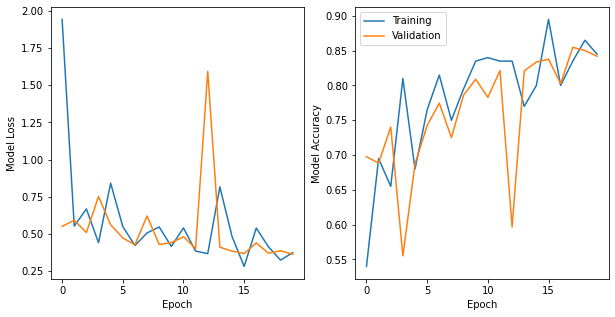

In [54]:
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(vgghist.history['loss'], label='Training')
ax[0].plot(vgghist.history['val_loss'], label='Validation')
ax[0].set_ylabel('Model Loss')
ax[0].set_xlabel('Epoch')
ax[1].plot(vgghist.history['acc'], label='Training')
ax[1].plot(vgghist.history['val_acc'], label='Validation')
ax[1].set_ylabel('Model Accuracy')
ax[1].set_xlabel('Epoch')
plt.legend()


## Prediction

In [55]:
image_batch, label_batch = next(iter(train_dataset))

# make predictions on test dataset
y_prob = model.predict(image_batch)


1/1 [==============================] - 0s 136ms/step


In [43]:
points = valid_dataset.map(lambda x, y: x)
labels = valid_dataset.map(lambda x, y: y)
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

110/110 [==============================] - 13s 117ms/step


In [56]:
[i.argmax() for i in y_prob]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:

# visualize 10 images from dataset
plt.figure(figsize=(20,20))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    img = image_batch[i].numpy()
    scaled_img = min_max_scale(img) 
    plt.imshow(scaled_img)
    plt.axis("off")
    y_class = y_prob[i].argmax()
    plt.title(f'Actual: {class_names[label_batch[i]][:10]},'
              f'\nPredicted: {class_names[y_class][:10]}')
plt.tight_layout()